# Выпускной проект "Мобильные приложения"

Проект выполнил и подготовил **Артем Осанов**

[**Презентация**](https://disk.yandex.ru/d/bZrccfGW_tbApw)
***

Датасет содержит данные о событиях, совершенных в мобильном приложении _"Ненужные вещи"_. В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после *7 октября 2019 года* по *3 ноября 2019 года* включительно.

Целью исследования является **нахождение особенностей и закономерностей в данных и презентация полученных результатов**. Результаты исследования могут быть учтены при разработке эффективных стратегий развития приложения.

## **Описание данных:**



Датасет **mobile_dataset.csv** содержит колонки:
* `event.time` — время совершения
* `event.name` — название события
* `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
* `userId` — идентификатор пользователя
* `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
* `advert_open` — открытие карточки объявления
* `photos_show` — просмотр фотографий в объявлении
* `tips_show` — пользователь увидел рекомендованные объявления
* `tips_click` — пользователь кликнул по рекомендованному объявлению
* `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
* `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
* `map` — пользователь открыл карту размещенных объявлений
* `search_1` — `search_7` — разные события, связанные с поиском по сайту
* `favorites_add` — добавление объявления в избранное

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import datetime as dt
from datetime import datetime, timedelta

In [3]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

In [4]:
path_cloud = '/kaggle/input/testttt/'
path_local = '/Users/osanov/Downloads/'

try:
    df = pd.read_csv(path_cloud + 'mobile_dataset.csv')
    sources = pd.read_csv(path_cloud + 'mobile_sources.csv')
except:
    df = pd.read_csv(path_local + 'mobile_dataset.csv')
    sources = pd.read_csv(path_local + 'mobile_sources.csv')
    
df_copy = df.copy()
sources_copy = sources.copy()

In [5]:
display(df.head(5))
sources.head()

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 74197 entries, 0 to 74196

Data columns (total 3 columns):

 #   Column      Non-Null Count  Dtype 

---  ------      --------------  ----- 

 0   event.time  74197 non-null  object

 1   event.name  74197 non-null  object

 2   user.id     74197 non-null  object

dtypes: object(3)

memory usage: 1.7+ MB


In [7]:
sources.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 4293 entries, 0 to 4292

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   userId  4293 non-null   object

 1   source  4293 non-null   object

dtypes: object(2)

memory usage: 67.2+ KB


Пропусков замечано не было. Необходимо будет привести столбец `event.time` к формату времени. 

In [8]:
df.describe()

event.time event.name  \
count                        74197      74197   
unique                       74197         16   
top     2019-10-07 00:00:00.431357  tips_show   
freq                             1      40055   

                                     user.id  
count                                  74197  
unique                                  4293  
top     cb36854f-570a-41f4-baa8-36680b396370  
freq                                     478

Всего 4293 уникальных пользователей. Один из них фигирирует в таблице с логами более 450 раз. 

In [9]:
sources.describe()

userId  source
count                                   4293    4293
unique                                  4293       3
top     020292ab-89bc-4156-9acf-68bc2783f894  yandex
freq                                       1    1934

То же число уникальных пользователей – это здорово. 3 источника, откуда приходят новые юзеры, Яндекс в топе с 1934 событиями. 

In [10]:
print(df.duplicated().sum())
sources.duplicated().sum()

0


0

Явных дубликатов нет.

In [11]:
display(df['event.time'].min())
df['event.time'].max()

'2019-10-07 00:00:00.431357'

'2019-11-03 23:58:12.532487'

### **Вывод:** 
Итого после предварительного просмотра данных у нас имеется:
* 74197 строка - всего в датафрейме `df`;
* 4293 строка - всего в датафрейме `sources`;
* `event.time` - неправильный тип данных;
* Неверный стиль именования столбцов;
* Явных дубликатов замечено не было;

## Предобработка данных

### Переименование столбцов

In [12]:
df = df.rename(columns={'event.time':'event_time',
                        'event.name':'event_name',
                        'user.id':'user_id'})

sources = sources.rename(columns={'userId':'user_id'})

### Приведение ячеек к нужному типу данных

Округлим время до милисекунд. Если округлить строки до секунд, то может появится больше количество дубликатов, связанных с показами фотографий и объявлений, когда пользователь быстро листает ленту или фотографии. 

In [13]:
df['event_time'] = pd.to_datetime(df['event_time'])
df['event_time'] = df['event_time'].dt.round('ms')

In [14]:
df

event_time   event_name  \
0     2019-10-07 00:00:00.431  advert_open   
1     2019-10-07 00:00:01.236    tips_show   
2     2019-10-07 00:00:02.245    tips_show   
3     2019-10-07 00:00:07.039    tips_show   
4     2019-10-07 00:00:56.320  advert_open   
...                       ...          ...   
74192 2019-11-03 23:53:29.535    tips_show   
74193 2019-11-03 23:54:00.407    tips_show   
74194 2019-11-03 23:56:57.042     search_1   
74195 2019-11-03 23:57:06.232    tips_show   
74196 2019-11-03 23:58:12.532    tips_show   

                                    user_id  
0      020292ab-89bc-4156-9acf-68bc2783f894  
1      020292ab-89bc-4156-9acf-68bc2783f894  
2      cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3      020292ab-89bc-4156-9acf-68bc2783f894  
4      cf7eda61-9349-469f-ac27-e5b6f5ec475c  
...                                     ...  
74192  28fccdf4-7b9e-42f5-bc73-439a265f20e9  
74193  28fccdf4-7b9e-42f5-bc73-439a265f20e9  
74194  20850c8f-4135-4059-b13b-198d3ac59902  
74195  28fccdf4-7b9e-42f5-bc73-439a265f20e9  
74196  28fccdf4-7b9e-42f5-bc73-439a265f20e9  

[74197 rows x 3 columns]

 ### Дубликаты

Проверим еще раз на дубликаты после форматирования строк с датами.

In [15]:
df.duplicated().sum()

43

In [16]:
# Выведем дубликаты:
qry = df.duplicated(keep=False)
qry = qry[qry == True].index.to_list()

df.loc[df.index.isin(qry)].tail(10)

event_time     event_name  \
63054 2019-10-30 17:51:29.513  contacts_show   
63055 2019-10-30 17:51:29.513  contacts_show   
64076 2019-10-31 01:15:46.542    photos_show   
64077 2019-10-31 01:15:46.542    photos_show   
65323 2019-10-31 14:26:23.643  contacts_show   
65324 2019-10-31 14:26:23.643  contacts_show   
68267 2019-11-01 15:55:10.041  contacts_show   
68268 2019-11-01 15:55:10.041  contacts_show   
69642 2019-11-02 09:16:05.041      tips_show   
69643 2019-11-02 09:16:05.041      tips_show   

                                    user_id  
63054  320cab3c-e823-4dff-8c01-c4253764640a  
63055  320cab3c-e823-4dff-8c01-c4253764640a  
64076  f29d922b-fc75-4eeb-a584-0c3532aa03d1  
64077  f29d922b-fc75-4eeb-a584-0c3532aa03d1  
65323  320cab3c-e823-4dff-8c01-c4253764640a  
65324  320cab3c-e823-4dff-8c01-c4253764640a  
68267  b814b321-58ca-4ab7-aaf6-fbe065343ea5  
68268  b814b321-58ca-4ab7-aaf6-fbe065343ea5  
69642  45c8980c-6840-42ec-8f23-152ad6c8e1e3  
69643  45c8980c-6840-42ec-8f23-152ad6c8e1e3

In [17]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

### Уникальные значения

Проверим уникальные значения в столбце `event_name`:

In [18]:
df.event_name.unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Здесь повторяются маркеры показа контакта – `contacts_show` и `show_contacts`. Заменим 2-ое на 1-ое во всем датафрейме. 

Также выделяются события поиска в приложении под разными номерами. Объединим их.

In [19]:
searches = ['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']

def contacts_rename(row):
    cell = row['event_name']
    if cell == 'show_contacts':
        return 'contacts_show'
    elif cell in searches:
        return 'search'
    else:
        return cell
    
df['event_name'] = df.apply(contacts_rename, axis=1)

In [20]:
df.event_name.unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

### Выделение сессий

Выделим сессии путем сортировки таблицы с логами событий и последщим добавлением уникального номера каждой, обозначив разрыв между 2 сессиями в 30 минут как условие для перехода к следующей. В "Яндекс.Аналитике" и "Google Analytics" именно тайм-аут в 30 минут бездействия определеяет окончание сессии по умолчанию. 

In [21]:
df = df.sort_values(by=['user_id', 'event_time'])

In [22]:
# определим разницу 40 минут для каждой группы с кумулятивной суммой
g = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()
# создаем счетчик групп
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1
df.tail(5)

event_time     event_name  \
72541 2019-11-03 15:51:23.960      tips_show   
72546 2019-11-03 15:51:57.900  contacts_show   
72641 2019-11-03 16:07:40.932      tips_show   
72645 2019-11-03 16:08:18.203      tips_show   
72646 2019-11-03 16:08:25.389      tips_show   

                                    user_id  session_id  
72541  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10368  
72546  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10368  
72641  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10368  
72645  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10368  
72646  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10368

Были добавлены уникальные идентификаторы сессий на основании, что после 40 минут бездействия от события, сессия заканчивается. Напишем функцию для построения таблицы с сессиями, куда войдут: `user_id`, `session_id` и время начала и конца сессии + источник, откуда пользователь пришел.

In [23]:
def get_sessions(df):
    
    session_s = (df.groupby(['session_id'])
             .agg({'event_time':'min'})
             .rename(columns={'event_time':'session_start'})
             .reset_index())

    session_e = (df.groupby(['session_id'])
             .agg({'event_time':'max'})
             .rename(columns={'event_time':'session_end'})
             .reset_index())
    
    # создаем таблицу сессий пользоватаелй
    sessions = df.merge(session_s,
                        on='session_id',
                        how='left', 
                        sort=True)
    sessions = sessions.merge(session_e, 
                              on='session_id', 
                              how='left',
                              sort=True)
    sessions = sessions.merge(sources,
                              on='user_id',
                              how='left', 
                              sort=True)
    
    sessions = sessions[['user_id',
                         'session_id', 
                         'source',
                         'session_start', 
                         'session_end']]
    sessions = (sessions
                .drop_duplicates()
                .reset_index(drop=True))
    
    return sessions

In [24]:
sessions = get_sessions(df)
sessions.head()

user_id  session_id  source  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1   other   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           2   other   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3   other   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           4   other   
4  00157779-810c-4498-9e05-a1e9e3cedf93           5  yandex   

            session_start             session_end  
0 2019-10-07 13:39:45.989 2019-10-07 13:49:41.717  
1 2019-10-09 18:33:55.578 2019-10-09 18:42:22.964  
2 2019-10-21 19:52:30.779 2019-10-21 20:07:30.051  
3 2019-10-22 11:18:14.635 2019-10-22 11:30:52.807  
4 2019-10-19 21:34:33.850 2019-10-19 21:59:54.637

### **Вывод:**
* 3 столбца – были переименованы в таблице с логами;
* 1 столбец – был переименованы в таблице с источниками;
* `Timestamp` – был использован как формат времени в `df`;
* 43 дубликата – было удалено из `df`;
* `df['event_name'] == 'search'` – включил в себя все события с поиском (`search_x`);
* `show_contacts` – было заменено на `contacts_show`;
* `session_id` – добавлен столбец с уникальнвм номером каждой сессии пользователя;
* `sessions` – новая таблица с информацией о сессиях пользователей.

## Исследовательский анализ данных


### Retention Rate

**Таблица с профилями пользователей**

Профили будут содержат информацию о первых визитах пользователей на сайт.

In [25]:
def get_profiles(ses):

    # находим параметры первых посещений
    profiles = (
        ses.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'source': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = profiles['dt'].astype('datetime64')
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'source'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        new_users[['dt', 'source']],
        on=['dt', 'source'],
        how='left',
    )
    
    return profiles

In [26]:
profiles = get_profiles(sessions)

**Таблица Retention Rate**

In [27]:
def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

Моментом анализа зададим последнюю доступную дату – *3 ноября 2019 года*; горизонт анализа будет равен 7-ми дням. Так мы рассмотрим еженедельную динамику коэффициента удержания пользователей. 

In [28]:
# задаём момент и горизонт анализа данных
observation_date = datetime(2019, 11, 3).date()
horizon_days = 7

# создаём опцию «игнорировать горизонт»
ignore_horizon = False

In [29]:
retention_raw, retention = get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon
)

In [30]:
retention.loc[:, 6].mean() * 100

6.02518768598611

**Среднее значение удержания** пользоваталей на 7-й день – **6.02%**.

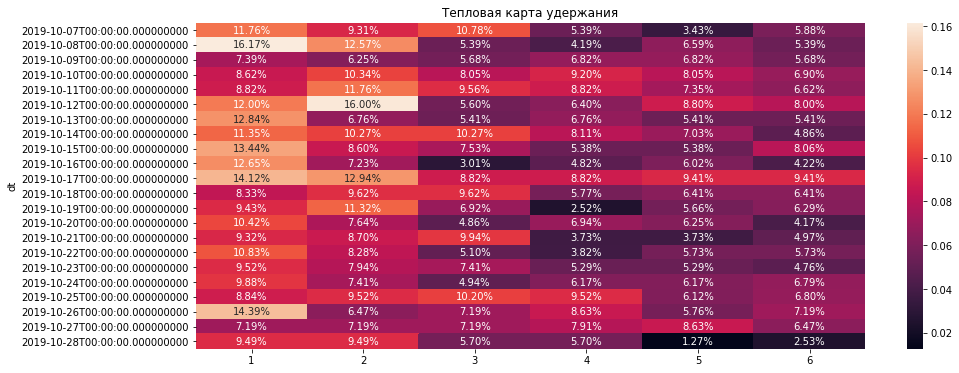

In [31]:
# строим хитмэп без нулевого лайфтайма

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

Коэффициенты в первый день очевидно одни из самых высоких; пик удержания во _2-й день_ пришелся на когорту от _8 октября 2019 года_ – порядка **16.17%** пользователей совершили действия на следующий после запуска день. Менее всего пользоватателей открыли софт компании _27 октября 2019 года_ – всего **7.19%** от 139 человек. 

Самый высокий показатель к/ф удержания на крайний день был от _18 октября 2019 года_ и равнялся **9.41%**; самый же низкий показатель за рассматриваемую неделю был на _3-й и 4-й дни_, когда retention rate был **8.82%**, повысившись впоследствии до **9.41%**. Одни из самых низких показателей от _28 октября_, когда коэффициент удержания понижался до **1.27%** от 158 человек. В целом, динамика такова, что пользователи, попавшие в когорты до _17 октября_ включительно, показали результаты лучше, чем после, но незначительно. 

In [32]:
#fig = px.bar(x=[2,3,4,5,6,7], 
#             y=list(round(retention.mean()[2:] * 100, 2)),
#             #text_auto=True, 
#             labels={'x':'День', 'y':'%'},
#             title=f'Процент среднего удержания пользователей по горизонту анализа')
#fig.show()

Если рассмотреть средний коэффициент удержания пользователей за весь период, то сделаем следующие выводы: 
* 10-11% от первоначального количества совершают действия на 2-ой день;
* 7-8% на 4 день, после чего спад замедляется;
* 6-6.5% в оставшиеся 3 дня.

**Вывод:** удержание пользователей покогортно на _7-й день_ выглядит не слишком стабильным. В последней когорте пользователей показатель упал до минимума за весь рассматриваемый период, а в когорте от середины месяца от показвал пиковые значения **в 4 раза** превышающие минимум. Если рассматривать среднее удержание для всех когорт по горизонту анализа, то уже _на 2 день_, в приложение заходит **в 10 раз** меньше людей, чем первоначальное количество. Удержание падает, хоть и не резко, и _после 4 дня_ снижается незначительно с **7.23%** до **6.03%** _на 7-й день_, что говорит о стабилизации показателя. 

### Время, проведённое в приложении

Рассчитаем, сколько длилась каждая из сессий, и выразим длительность в минутах:

In [33]:
sessions['time_spent'] = (sessions['session_end'] - sessions['session_start']).astype('timedelta64[m]')

Добавим условие – если длительность сессии равна 0, то заменим нулевое значения на пропуск. Причина такого решения следующая: последний лог пользовательского действия используется при добавлении временного значения в столбец `session_end`. Так, например, при совершении единственного действия в сессии значения времени в начале и конце сессии равны между собой и при разности двух столбцов будут выдавать нули, которые, в свою очередь, будут влиять на расчет среднего и других числовых метрик. 

Но сначала посмотрим, сколько сессий длились 0 минут, то есть пользователь вошел в приложение, было произведено 1 действие и юзер вышел. Возможно, есть какая-то закономерность или технический сбой в приложении.

In [34]:
sessions[sessions['time_spent'] == 0].shape[0] / sessions.shape[0] * 100

29.629629629629626

__29.6%__ всех времени всех сессий равны 0

In [35]:
(df[
    df['session_id'].isin(sessions[sessions['time_spent'] == 0].session_id.tolist())]
 .groupby('event_name')[['session_id']]
 .count()
 .sort_values(by='session_id',
              ascending=False))

session_id
event_name               
tips_show            1572
photos_show          1102
search                999
contacts_show         370
map                   215
advert_open           196
contacts_call          97
favorites_add          59
tips_click             24

Чаще всего люди вероятно закрывали приложение после просмотра рекомендации, просмотра фотографий карточки обхявления и поиска. 

In [36]:
sessions.loc[sessions['time_spent'] == 0, 'time_spent'] = np.nan

In [37]:
sessions[['time_spent']].describe()

time_spent
count    7,296.00
mean        17.76
std         21.51
min          1.00
25%          4.00
50%         11.00
75%         23.00
max        321.00

В среднем пользовательская сессия длится *19 минут 44 секунды*, с медианой в *11 минут*. Максимальная продолжительность сессии составила *367 минут* или *6 часов 7 минут*, соответственно. Длительность первого квартиля всех сессий *(~1,800 сессий)* ниже *4 минут*, а 3-его – более *26 минут*. 

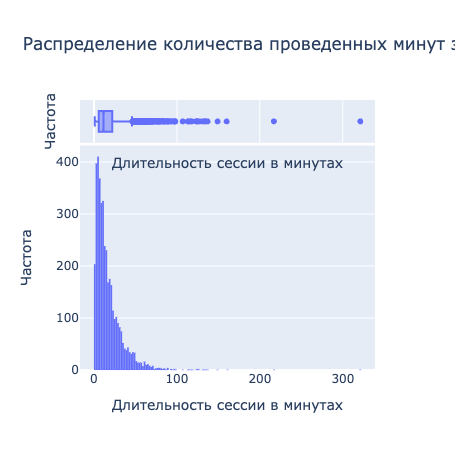

In [38]:
session_time = (sessions.groupby('user_id')[['time_spent']]
         .mean()
         #.sort_values(by='time_spent', 
         #             ascending=False)
         .reset_index())

fig = px.histogram(session_time, 
             x='time_spent',
             y=session_time.index,
             histfunc='count',
             marginal="box",    
             hover_data=session_time.columns   ,          
             title='Распределение количества проведенных минут за сессию с группировкой по пользователю',
             text_auto=False)

fig.update_xaxes(title_text="Длительность сессии в минутах")
fig.update_yaxes(title_text="Частота")

Граница максимальных значений средней длительности сессии юзера ограничена *52 минутами*. *50%* средней длительности сессий находятся по обе стороны значения *12.2 минуты*. После сессий длиною в *100 минут* частота значений заметно снижается и по большей части равна *1 случаю*. Так, гистограмма показывает о выбросах, как раз после высшей границы "нормальных" значений. Есть характерный выброс, когда средние сессии пользователя *более 5 часов*. 

In [39]:
sessions['dt'] = sessions['session_start'].dt.date

In [40]:
time_table = sessions.pivot_table(index='dt', values='time_spent', aggfunc=['sum', 'mean']).reset_index()
time_table.columns = time_table.columns.droplevel(1)
time_table['dt'] = pd.to_datetime(time_table['dt'])
time_table['day'] = time_table['dt'].dt.day_name()

In [41]:
time_table['7day_rolling_avg_sum'] = time_table['sum'].rolling(7).mean()
time_table['7day_rolling_avg_mean'] = time_table['mean'].rolling(7).mean()

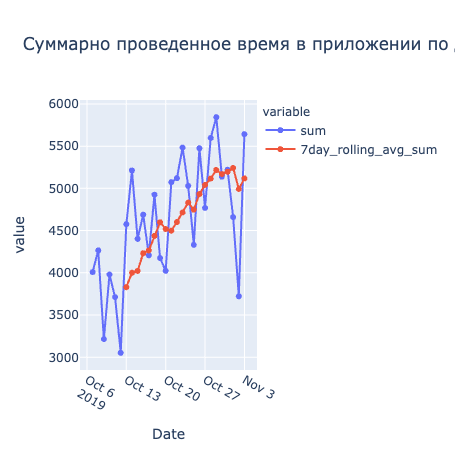

In [42]:
fig = px.line(time_table, 
             x='dt',
             y=['sum', '7day_rolling_avg_sum'], markers=True,
             labels={'sum':'Сумма минут', 'dt':'Date'},
             title='Суммарно проведенное время в приложении по дням')
fig.show()

На графике линия скользящего среднего указавает на явную тенденцию роста минут в приложении от дня к дню. В целом, за изучаемый промежуток времени ежедневно суммарно проведенное время в приложении выросло с *4325 минут до 6310 минут в день*, что является положительной динамикой. Но также на графике заметны ямы, такие как от *2 ноября 2019 года* и *12 октября 2019 г.*. 

График нельзя интерпритировать без среднего времени, которое пользователи провели за день, так как с увелечением суммарного времени могло вырасти и количество юзеров. Построим график среднего пользования приложения за *4 недели ежедневно*. 

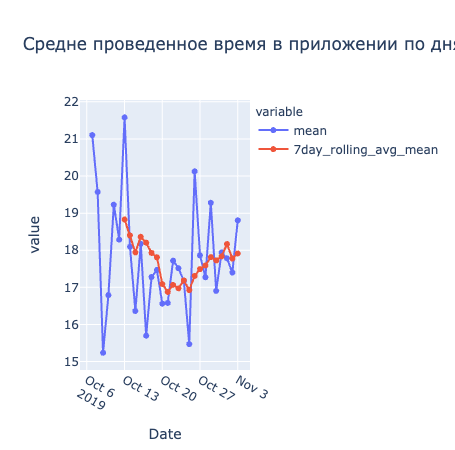

In [43]:
fig = px.line(time_table, 
             x='dt',
             y=['mean','7day_rolling_avg_mean'], markers=True,
             labels={'mean':'В среднем минут', 'dt':'Date'},
             title='Средне проведенное время в приложении по дням, минуты')
fig.show()

Здесь ситуация обратная – в среднем пользователи стали проводить меньше времени. *23.1 минута 7 октября* и *21.8 минута 3 ноября*. В целом значения времени выглядят **хаотично**. Показатель средне проведенного времени резко падал до своего минимума *9 октября* (*16.2 минуты*, **-27%** от предыдущего дня) и был резкий рост *13 октября* с *19.1 до 23.4 минут* (**22.5%** роста за день). 

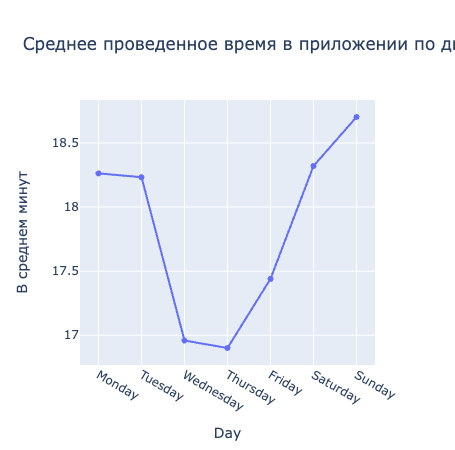

In [44]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_mean = time_table.groupby('day')[['mean']].mean().reindex(cats).reset_index()

fig = px.line(day_mean, 
             x=day_mean.day,
             y='mean', markers=True,
             labels={'mean':'В среднем минут', 'day':'Day'},
             title='Среднее проведенное время в приложении по дням недели')
fig.show()

В будние дни пользователи меньше проводят времени в приложении, показатель падает от понедельника по четверг, но уже в пятницу есть небольшой рост, сопровождающийся бурным в субботу и воскресенье. Так, пик средне проведенного времени приходиься на воскресенья – 21.2 минуты в среднем, минимум на четверги – 18.5 минут. В будние дни по понедельникам сидят в приложении дольше всего – по 20.3 минут в день.

**Вывод:** Пользователи заходят в приложение, когда есть свободное время. Общее время пользования приложением хоть и выросло, но среднее упало. Но все равно это хорошо, так как приходят новые пользователи. 

### Частота действий

In [45]:
freq_table = (df.groupby('event_name')['event_time']
              .count()
              .reset_index()
              .sort_values(by='event_time',
                           ascending=False))
freq_table = freq_table.rename(columns={'event_time':'freq'})
freq_table['%'] = round(freq_table['freq'] / freq_table['freq'].sum() * 100, 2)

In [46]:
freq_table

event_name   freq     %
8      tips_show  40053 54.01
5    photos_show   9997 13.48
6         search   6784  9.15
0    advert_open   6161  8.31
2  contacts_show   4515  6.09
4            map   3873  5.22
3  favorites_add   1417  1.91
7     tips_click    813  1.10
1  contacts_call    541  0.73

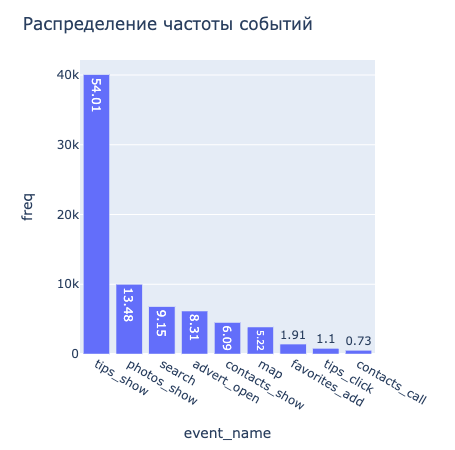

In [47]:
labels = freq_table['event_name']
values = freq_table['freq']
title='Распределение частоты событий'

fig = px.bar(freq_table, 
             x=labels,
             y=values,
             text='%')
fig.update_layout(title_text=title)
fig.show()

Более половины всех логов действий – это показ в приложении рекомендованного объявления (54%), при этом согласно диаграмме, только 1.1% кликали на рекомендованные показы, что может говорить о необходимости доработки алгоритмов рекомендаций. Самым редким событием является звонок по номеру телефона, указанному на карточке объявления (всего 0.73% от всех событий), данное действие является максимальным интересом пользователя к объявлению и наивысшим потенциалом для покупки товара/услуги, указанного в карточке. 

Поиск, просмотр фотографий, открытие карты размещенных объявлений – обычные события с долями от 5 до 13% от всех событий. Юзеры редко добавляют карточки товаров или услуг в избранное (1.91% или 1417 раза). 8.3% событий – это открытие карточки объявлений и 6% от всех событий – это показ контактов. 

In [48]:
df['event_day'] = df['event_time'].dt.date
df['event_day'] = pd.to_datetime(df['event_day'])

In [49]:
freq_table = (df.groupby(['event_day', 'event_name'])['event_time']
              .count()
              .reset_index()
              .sort_values(by='event_day',
                           ascending=True))
freq_table = freq_table.rename(columns={'event_time':'freq'})
freq_table['event_day'] = pd.to_datetime(freq_table['event_day'])
freq_table['day'] = freq_table['event_day'].dt.isocalendar().day
freq_table = freq_table.groupby(['day', 'event_name'])[['freq']].mean().reset_index()

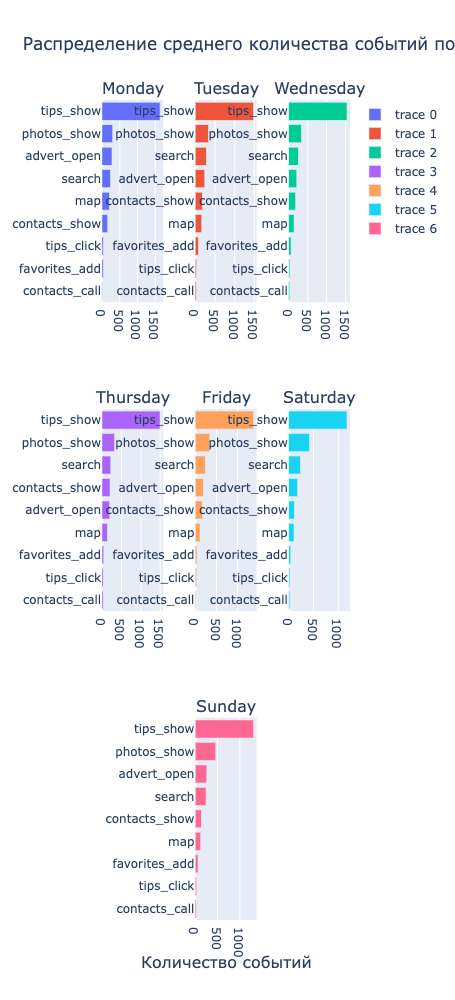

In [50]:
days = [1,2,3,4,5,6,7]
rows = [1, 1, 1, 2, 2, 2, 3]
cols = [1, 2, 3, 1, 2, 3, 2]

fig = make_subplots(rows=3,
                    cols=3,
                    vertical_spacing=0.13,
                    horizontal_spacing=0.13,
                    x_title='Количество событий',
                    #y_title='Событие',
                    subplot_titles=("Monday", 
                                    "Tuesday",
                                    "Wednesday",
                                    "Thursday",
                                    "Friday",
                                    "Saturday",
                                    '' ,
                                    "Sunday"))
                                    
for day, row, col in zip(days, rows, cols):
    Y = freq_table[freq_table['day'] == day].sort_values(by='freq')
    fig.add_trace(go.Bar(y=Y['event_name'], 
                         x=Y['freq'], orientation='h', text = Y['freq']), row=row, col=col)

    
#fig.update_xaxes(title_text="Количество событий")
#fig.update_yaxes(title_text="Событие")

fig.update_layout(height=1000, width=1000, title_text="Распределение среднего количества событий по дням недели")
fig.show()

Примечательно, что в выходные в среднем событий меньше, чем в будние дни, несмотря на более продолжительные средние сессии. Самое популярное действие, как и в общей картине – это показ пользователю рекомендуемой карточки объявления, на втором месте во все дни идут просмотры фотографий карточек. В понедельник и воскресенье, самые активные дни, на 3-м месте по популярности открытия карточек товаров / услуг, тогда как в остальные дни люди охотнее осуществляют поиск. В остальные же дни ситуация одинакова – после просмотра карточек и поиска, идут просмотр конактов, открытие карты, добавление в избранное, открытие рекомендации и звонок. 

In [51]:
sessions_user = df.pivot_table(index='user_id', 
               values=['event_name', 'session_id'],
               aggfunc={'event_name':'count', 'session_id':'nunique'}).reset_index()

In [52]:
profiles['events_per_session'] = sessions_user['event_name'] / sessions_user['session_id']

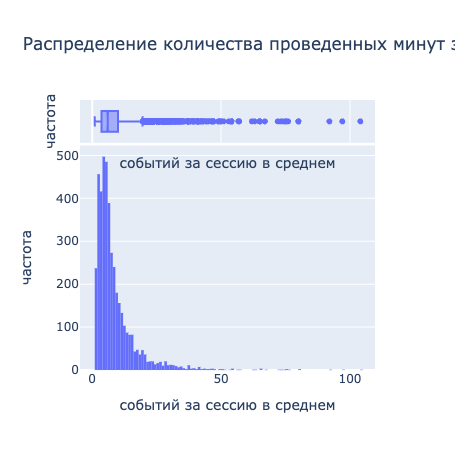

In [53]:
fig = px.histogram(profiles, 
             x='events_per_session',
             y=profiles.index,
             histfunc='count',
             marginal="box",    
             hover_data=profiles.columns   ,          
             title='Распределение количества проведенных минут за сессию с группировкой по пользователю',
             text_auto=False)

fig.update_xaxes(title_text="событий за сессию в среднем")
fig.update_yaxes(title_text="частота")

In [54]:
profiles[['events_per_session']].describe()

events_per_session
count            4,293.00
mean                 8.29
std                  8.39
min                  1.00
25%                  3.67
50%                  6.00
75%                 10.00
max                104.00

Граница выбросов – 19 событий за сессию. В целом пользователм совершают в среднем 8.5 событий или 6 в медиане. 25% юзеров делают более 10 действий за сессию и 25% менее 4. 

**Вывод:** пользователи получают много рекомендаций, но редко на них нажимают. В выходные пользователи предпочитают совершать меньше действий, чем в будни, но чаще именно просматривают объявления, чем осуществляют поиск. Очень редко совершаются звонки. 

### Конверсия в целевое действие — просмотр контактов.

In [55]:
conversion = (df[df['event_name'] == 'contacts_show']['user_id'].nunique() / df['user_id'].nunique() * 100)
conversion = round(conversion, 2)
print(f"Конверсия в целевое действие за весь рассматриваемый период: {conversion}%")

Конверсия в целевое действие за весь рассматриваемый период: 22.85%


In [56]:
df['week'] = df['event_time'].dt.isocalendar().week
df['day'] = df['event_time'].dt.isocalendar().day

Напишем функцию для высчитывания конверсии в динамике по неделям и дням недели

In [57]:
def conv_dyn(arg, listik, condition, df=df):
    c = 0
    conv = []
    
    for i in sorted(df[arg].unique().tolist()):
        conversion = (df[(df['event_name'] == 'contacts_show') & (df[arg] == i)]['user_id'].nunique() / df[df[arg] == i]['user_id'].nunique() * 100)
        conversion = round(conversion, 2)
        conv.append(conversion)
        #print(f"Конверсия в целевое действие в среднем за {listik[c]}: {conversion}%")
        c += 1
    
    res = {}
    for c in listik:
        for value in conv:
            res[c] = value
            conv.remove(value)
            break

    fig = px.bar(x=list(res.keys()), 
                    y=list(res.values()),
                    text_auto=True, 
                    labels={'x':'Дни/Номера недели', 'y':'%'},
                    title=f'Конверсия в целевое действие – просмотр контактов – {condition}')
    #fig.update_yaxes(range=[14,25])
    return fig

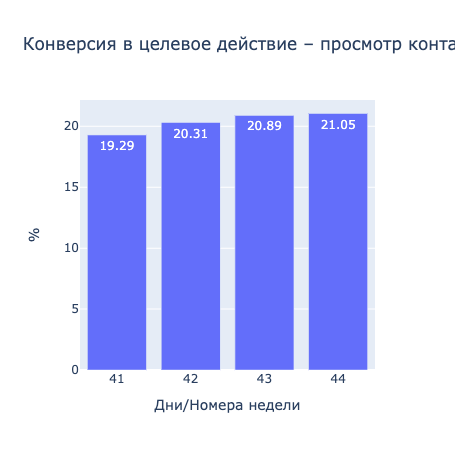

In [58]:
week_numbers = df['week'].unique().tolist()
week_numbers = sorted(week_numbers)

conv_dyn('week', week_numbers, 'понедельно')

Постепенно конверсия начала расти от недели к неделе. Так, от 19.3% в первую изучаемую неделю до 21.05% в крайнюю доступную. 

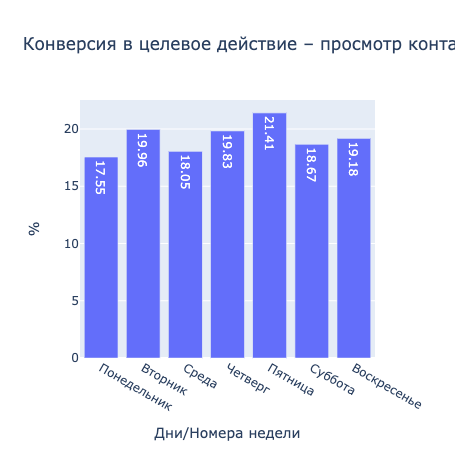

In [59]:
week_days = ['Понедельник', "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]

conv_dyn('day', week_days, "в среднем по дням недели")

Пятница и вторник – дни, когда пользователи оказывают высокий интерес к карточкам, 21.4% и 20%, соответственно. Какой-то взаимосвязи конверсии от буднего дня или выходного нет. В понедельник, когда совнершается больше всего действий и средняя продолжительность сессии достаточно высока, конверсия крайне мала. Видимо, пользователи заходят в приложение менее нацеленно найти что-то необходимое и просто просматривают карточки, чтобы скоротать время, чем, например, в пятницу. 

**Вывод:** Была замечена тенденция к росту конерсии в просмотр контактов от первой к четвертой недели. Средняя конверсия по дням недели выше всего в пятницу и вторник. 

### **Вывод:**

Пользователи показывают невысокий уровень удержания – порядка 6% на 7-день. Считается, что хорошим показателем retention rate на 7 день является значение в диапазоне от 20% до 40%. Приложения с retention rate на 7 день более 40% считаются очень успешными, тогда как приложения с retention rate ниже 20% могут иметь проблемы с удержанием пользователей и, как следствие, с ростом бизнеса.

Общее время в приложении растет за счет увелечения новых пользоваталей, но среднее время на пользователя за день показывает стагнацию – к середине октября падаение и последующий медленный рост показателя. В выходные и понедельник – в среднем больше проводят времени в аппликации. Но 29% длительности от всех сессий равны 0. Данные показывают, после какого действия была завершена сессия и в топ-3 находятся показ рекомендаций, просмотр фото и поиск. Возможно стоит поработать над поиском решения проблемы алгоритмов рекомендаций и поиска. И, может, стоит пофиксить просмотр фотографий. 

В будние дни люди склонны чаще совершать действия в приложении. Но поведение в приложении в эти дни говорит, что пользователи не слишком ответственно и серьезно подходят к поиску нужного им товара (или услуги), чем в выходные, когда лишних действий меньше (таких как поиск, просмотр фото).


Конверсия улучшилась с течением 4 недель и выросла на почти 2% – с 19.29% до 21.05%. Если смотреть на динамику по дням недели, то вторник и пятница – вероятно самые покупные дни, потому что именно в них совершается более всего просмотров карточек контактов, и как следствие, последующие звонки. 



## Основная цель исследования

### Сегментирование пользователей на основе действий

Для составления таблицы, где будут сегментированы пользователи, определим признаки и их критерии для сегментации. Всего будет принято во внимание 4 основных признака:
- *Количество сессий за весь период*
- *Среднее время сессии*
- *Среднее кол-во действий за сессию*
- *Коэффициент удержания*

#### Количество сессий

In [60]:
sessions_total = (sessions
                  .groupby('user_id')[['session_id']]
                  .count()
                  .sort_values(by='session_id',
                               ascending=False)
                  .reset_index()
                 )

#### Среднее время сессии

In [61]:
avg_time_per_session = (sessions
                   .groupby('user_id')[['time_spent']]
                   .mean()
                   .sort_values(by='time_spent',
                                ascending=False)
                   .reset_index()
                  )

#### Среденее кол-во действий за сессию

In [62]:
avg_events_per_session = (df
                      .groupby(['user_id', 'session_id'])[['event_name']]
                      .count()
                      .reset_index()
                     )
avg_events_per_session = (avg_events_per_session
                      .groupby('user_id')[['event_name']]
                      .mean()
                      .reset_index()
                     )

Объединим таблицы в одну по столбцу с уникальными идентификаторами пользователей и назовем ее `segment`.

In [63]:
segment = sessions_total.merge(avg_time_per_session, on='user_id', how='left')
segment = segment.merge(avg_events_per_session, on='user_id', how='left')
segment = segment.fillna(0)
segment = segment.rename(columns={'session_id':'sessions_total',
                                  'time_spent':'avg_time_per_session',
                                  'event_name':'avg_events_per_session'})
segment.head(3)

user_id  sessions_total  avg_time_per_session  \
0  21230dd9-2f7f-4b77-a436-43d4d10388e0              99                 19.13   
1  1580911b-65db-4f1a-be7e-1ca39becac30              52                 13.21   
2  cb36854f-570a-41f4-baa8-36680b396370              50                 40.63   

   avg_events_per_session  
0                    4.04  
1                    5.10  
2                    9.56

#### Удержание

In [64]:
retention.iloc[:, [0,7]].describe()

cohort_size     6
count        22.00 22.00
mean        161.27  0.06
std          19.48  0.02
min         125.00  0.03
25%         147.25  0.05
50%         160.00  0.06
75%         173.00  0.07
max         204.00  0.09

Всего есть 22 когорты, в каждой из которых в среднем около 161 человека (3548 юзеров вошли в анализ). Будут вывыделены следующие критерии, по которым пользователь попадет в одну из 3 групп:
* **Группа 1 (значение 3)** – пользователь в когорте, для которой показатель коэффициента удержания на 7-й день **выше или равен 7%**;
* **Группа 2 (значение 2)**– пользователь в когорте, для которой показатель коэффициента удержания на 7-й день **от 5% до 7%**;
* **Группа 3 (значение 1)** – пользователь в когорте, для которой показатель коэффициента удержания на 7-й день **ниже или равен 5%**.

Для тех пользоваталей, которые **не попали** в анализ, **расставим 0**. 

In [65]:
groups = {}
for i in range(1,4):
    if i == 3:
        cond = retention.iloc[:, 7] >= 0.07
    elif i == 2:
        cond = (retention.iloc[:, 7] > 0.05) & (retention.iloc[:, 7] < 0.07)
    else:
        cond = retention.iloc[:, 7] <= 0.05
    group = retention[cond].reset_index()
    group = group['dt'].tolist()
    groups[i] = profiles[profiles['dt'].isin(group)][['user_id']]
    
group_1, group_2, group_3 = groups.values()

# Последняя группа нужна лишь для проверки
exclude = group_1.user_id.tolist() + group_2.user_id.tolist() + group_3.user_id.tolist()
group_0 = profiles[~profiles['user_id'].isin(exclude)][['user_id']]

In [66]:
group_0.nunique() + group_1.nunique() + group_2.nunique() + group_3.nunique()

user_id    4293
dtype: int64

Отлично, учли всех пользоваталей. Приступим к добавлению столбца с информацией. 

In [67]:
def segment_group(row):
    cell = row['user_id']
    if cell in group_1['user_id'].values:
        return 3
    elif cell in group_2['user_id'].values:
        return 2
    elif cell in group_3['user_id'].values:
        return 1
    else:
        return 0

segment['group'] = segment.apply(segment_group, axis=1)
segment['group'] = segment['group'].astype(int)

In [68]:
segment.head(2)

user_id  sessions_total  avg_time_per_session  \
0  21230dd9-2f7f-4b77-a436-43d4d10388e0              99                 19.13   
1  1580911b-65db-4f1a-be7e-1ca39becac30              52                 13.21   

   avg_events_per_session  group  
0                    4.04      2  
1                    5.10      2

#### Система оценки

Теперь, после добавление всех признаков, нам нужно повторить действия и расставить значения по 3-х бальной шкале каждому пользователю в соответствии с критериями признаков. 

In [69]:
segment.iloc[:, :4].describe()

sessions_total  avg_time_per_session  avg_events_per_session
count        4,293.00              4,293.00                4,293.00
mean             2.42                 15.78                    8.29
std              3.54                 17.29                    8.39
min              1.00                  0.00                    1.00
25%              1.00                  5.00                    3.67
50%              1.00                 11.00                    6.00
75%              3.00                 21.00                   10.00
max             99.00                321.00                  104.00

*Общее количество сессий:*
- **Группа 1 (значение 3)**: 2 и более сессии за месяц;
- **Группа 2 (значение 2)**: более 1 сессии за месяц;
- **Группа 3 (значение 1)**: всего 1 сессия за месяц;

*Среднее время сессии:*
- **Группа 1 (значение 3)**: средняя продолжительность сессии 11 минут и более;
- **Группа 2 (значение 2)**: средняя продолжительность сессии более 5 минут, но менее 11 минут;
- **Группа 3 (значение 1)**: средняя продолжительность сессии менее 5 минут;

*Среднее количество событий за сессию:*
- **Группа 1 (значение 3)**: количество действий пользователя в среднем за сессию 6 и более;
- **Группа 2 (значение 2)**: количество действий пользователя в среднем за сессию более 4, но менее 6;
- **Группа 3 (значение 1)**: количество действий пользователя в среднем за сессию 4 и менее.

In [70]:
segment_rates = segment.copy()

In [71]:
# display(segment_rates.groupby(['sessions_total'])[['sessions_total']].count())
# display(segment_rates.groupby(['avg_time_per_session'])[['avg_time_per_session']].count())
# display(segment_rates.groupby(['avg_events_per_session'])[['avg_events_per_session']].count())
# display(segment_rates.groupby(['group'])[['group']].count())

In [72]:
# Определяем лямбда-функции для сопоставления
map_sessions_total = lambda x: 1 if x < 2 else 3 if x >= 2 else 2
map_avg_time_per_session = lambda x: 1 if x < 5 else 3 if x >= 11 else 2
map_avg_events_per_session = lambda x: 1 if x <= 4 else 3 if x >= 6 else 2

# Применяем лямбда-функции к столбцам
segment_rates['sessions_total'] = segment_rates['sessions_total'].apply(map_sessions_total).astype(int)
segment_rates['avg_time_per_session'] = segment_rates['avg_time_per_session'].apply(map_avg_time_per_session).astype(int)
segment_rates['avg_events_per_session'] = segment_rates['avg_events_per_session'].apply(map_avg_events_per_session).astype(int)


**Теперь считаем сумму значений каждой строки:**

In [73]:
segment_rates['sum'] = segment_rates['sessions_total'] + segment_rates['avg_time_per_session'] + segment_rates['avg_events_per_session'] + segment_rates['group'] 

#### Cегментирование

Сегментирование будет следующим: 
* ***Сегмент 1 (10-12 балл)*** – самые активные пользователи по среднему времени за сессию, количеству действий в среднем, кол-ву сессий и retention rate. Целевая аудитория приложения;
* ***Сегмент 2 (7-9 балл)*** – менее активные пользователи. Но все же показывающие достаточную активность. Могут оказаться в составе ЦА в ближайшем будущем;
* ***Сегмент 3 (3-6 балл)*** – слабо активные пользователи. Сюда входят как свежеприбывшие (получили 0 баллов в удержании), так и вовсе незаинтерисованные пользователи.



In [74]:
map_segment = lambda x: 3 if x <= 6 else 1 if x >= 10 else 2
segment_rates['segment'] = segment_rates['sum'].apply(map_segment).astype(int)


In [75]:
#map_segment = lambda x: 4 if x <= 3 else 1 if x >= 10 else 3 if x >= 4 and x <=6 else 2
#segment_rates['segment'] = segment_rates['sum'].apply(map_segment).astype(int)

In [76]:
sements_count = segment_rates.groupby(['segment'])[['segment']].count()

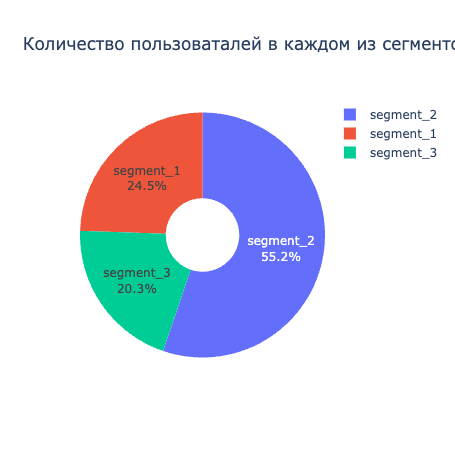

In [77]:
labels = ['segment_1', 'segment_2', 'segment_3']
values = sements_count['segment']
title='Количество пользоваталей в каждом из сегментов'

fig = go.Figure(data=[go.Pie(labels=labels,
                         values=values,
                         textinfo='label+percent',
                         hole=.3)])
fig.update_layout(title_text=title)
fig.show()

**Вывод:** Было проведено сегментирование по количеству сессий, среднему времени сессий, среднему кол-ву действий за сессию и коэффициену удержания. Выделены 3 группы пользоваталей.

Половина всех пользователй – относительно активные юзеры, показывающие хорошую активность  – 55.2%. Примерно поровну поделились остальные на максимально активных и почти незаинтерисованных пользователей – 24.5% и 20.3%, соответственно. 

### Retention Rate по сегментам

Задача: *Пользователи какой группы склонны чаще возвращаться в мобильное приложение (Retention rate)?*

In [78]:
segment_1 = segment_rates[segment_rates['segment'] == 1].user_id.to_list()
segment_2 = segment_rates[segment_rates['segment'] == 2].user_id.to_list()
segment_3 = segment_rates[segment_rates['segment'] == 3].user_id.to_list()

In [79]:
sessions = [get_sessions(df[df['user_id'].isin(users)]) for users in [segment_1, segment_2, segment_3]]
profiles = [get_profiles(sessions[i]) for i in range(3)]
retentions = [get_retention(profiles[i], sessions[i], observation_date, horizon_days, ignore_horizon)[1] for i in range(3)]

In [80]:
retention_s1, retention_s2, retention_s3 = retentions

In [81]:
def segment_retention(retention_s):
    retention  = retention_s.iloc[:, 7].mean() * 100
    return retention

for i, retention_s in enumerate([retention_s1, retention_s2, retention_s3], 1):
    print(f"Конверсия в целевое действие за весь рассматриваемый период Сегмента {i}: {round(segment_retention(retention_s),2)}%")

Конверсия в целевое действие за весь рассматриваемый период Сегмента 1: 12.6%

Конверсия в целевое действие за весь рассматриваемый период Сегмента 2: 4.75%

Конверсия в целевое действие за весь рассматриваемый период Сегмента 3: 0.95%


Неудивительно, что для первого сегмента пользователей удержание наивысшее – в данный кластер входят наиболее активные юзеры. Второй сегмент показал результат (4.75%), близкий для всех пользователей в целом, рассчитанный ранее – 6.02% –, но чуть ниже. Для пользоваталей сегмента 3 среднее удержание близко к 1%, что означает, что из 100 человек в когорте на 1 день, на 7 день в приложение зайдет только 1. 

Взглянем на тепловые карты по сегментам:

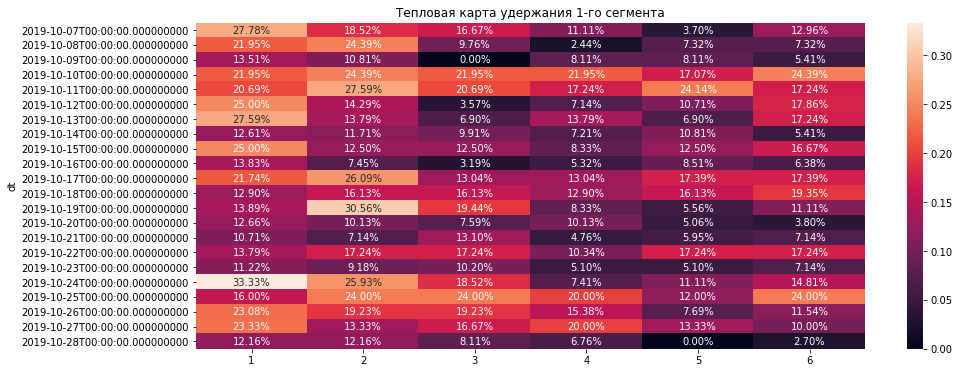

In [82]:
plt.figure(figsize=(15, 6)) 
sns.heatmap(
    retention_s1.drop(columns=['cohort_size', 0]),  
    annot=True, 
    fmt='.2%', 
)
plt.title('Тепловая карта удержания 1-го сегмента') 
plt.show()

Очень яркие ячейки на 2 день – до 33% пользователй заходят в аппку. В целом положитнльная динамика. 

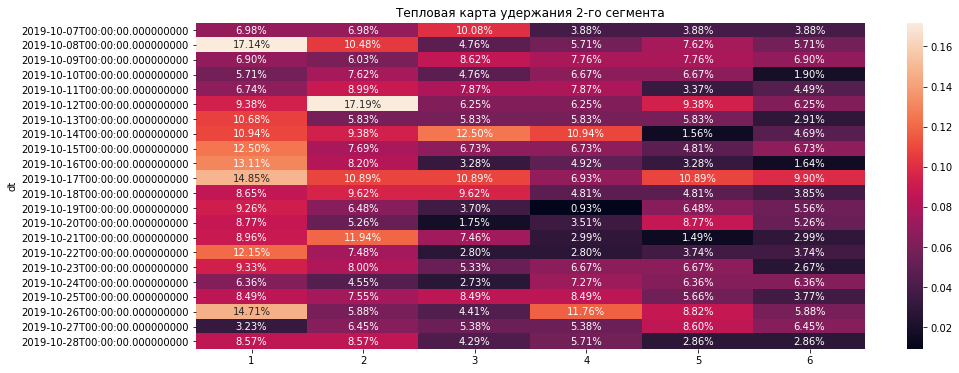

In [83]:
plt.figure(figsize=(15, 6)) 
sns.heatmap(
    retention_s2.drop(columns=['cohort_size', 0]),  
    annot=True, 
    fmt='.2%', 
)
plt.title('Тепловая карта удержания 2-го сегмента') 
plt.show()

Данная карта не такая яркая, как первая. На 7-й день, цвета ячеек в преобладающем количестве заполнены темными оттенками. Были и когорты, похожие по характеристике удержание на 1-ю когорту, например, от 9 и 17 октября. 

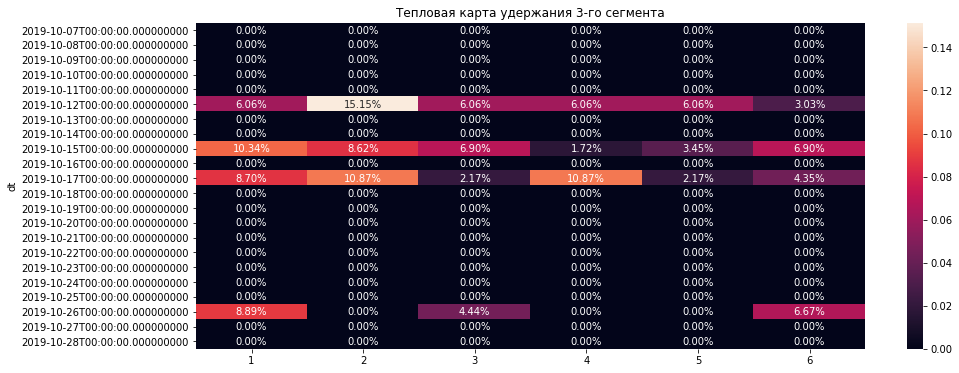

In [84]:
plt.figure(figsize=(15, 6)) 
sns.heatmap(
    retention_s3.drop(columns=['cohort_size', 0]),  
    annot=True, 
    fmt='.2%', 
)
plt.title('Тепловая карта удержания 3-го сегмента') 
plt.show()

Для 3-го сегмента удержания когорт почти везде равно 0. Сюда вошли пользователи, которые заходили в приложение разово. Поэтому retention в основном равен 0%. 

In [85]:
#xl = [2,3,4,5,6,7]
#tt = list(round(retention_s1.mean()[2:] * 100, 2))
#d = {'day':[2,3,4,5,6,7], 'conversion':list(round(retention_s1.mean()[2:] * 100, 2))}
#

In [86]:
ss1 = pd.DataFrame(data={'day':[2,3,4,5,6,7], 'retention':list(round(retention_s1.mean()[2:] * 100, 2))})
ss1['segment'] = '1'

ss2 = pd.DataFrame(data={'day':[2,3,4,5,6,7], 'retention':list(round(retention_s2.mean()[2:] * 100, 2))})
ss2['segment'] ='2'

ss3 = pd.DataFrame(data={'day':[2,3,4,5,6,7], 'retention':list(round(retention_s3.mean()[2:] * 100, 2))})
ss3['segment'] = '3'

In [87]:
ret_seg = pd.concat([ss1,ss2,ss3],ignore_index=True, axis=0, )

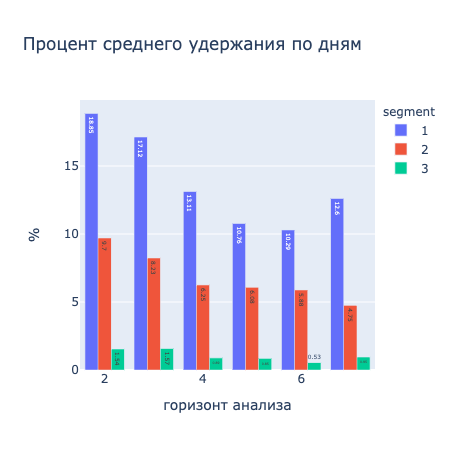

In [88]:
fig = px.bar(ret_seg, x='day', 
             y='retention', color='segment',
             text_auto=True,  barmode='group',
             labels={'day':'горизонт анализа', 'retention':'%'},
             title=f'Процент среднего удержания по дням')
fig.show()

Для всех трех групп retention нисходящий, кроме сегментов 1 и 3 на 7-й день, когда среднее удержание выросло в сравнении с предыдущим днем, но это скорее исключение из правил. 

**Вывод:** Ввиду сегментировании по активности, retention rate для более активных групп очевидно выше, чем для менее. 

### Конверсия по сегментам

Задача: *Пользователи какой группы чаще совершают просмотр контактов (конверсия в целевое действие)?*


In [89]:
def segment_conversion(segment):
    conversion = (df[(df['event_name'] == 'contacts_show') & (df['user_id'].isin(segment))]['user_id'].nunique() / df[df['user_id'].isin(segment)]['user_id'].nunique() * 100)
    conversion = round(conversion, 2)
    return conversion

for i, segment in enumerate([segment_1, segment_2, segment_3], 1):
    print(f"Конверсия в целевое действие за весь рассматриваемый период Сегмента {i}: {segment_conversion(segment)}%")

Конверсия в целевое действие за весь рассматриваемый период Сегмента 1: 30.38%

Конверсия в целевое действие за весь рассматриваемый период Сегмента 2: 22.41%

Конверсия в целевое действие за весь рассматриваемый период Сегмента 3: 15.01%


In [90]:
segment_1_users = segment_1.copy()
segment_1 = df[df['user_id'].isin(segment_1_users)]

In [91]:
segment_2_users = segment_2.copy()
segment_2 = df[df['user_id'].isin(segment_2_users)]

In [92]:
segment_3_users = segment_3.copy()
segment_3 = df[df['user_id'].isin(segment_3_users)]

In [93]:
def conv_dyn_segments(arg, listik, x, df=df):
    c = 0
    conv = []
    
    for i in sorted(df[arg].unique().tolist()):
        conversion = (df[(df['event_name'] == 'contacts_show') & (df[arg] == i)]['user_id'].nunique() / df[df[arg] == i]['user_id'].nunique() * 100)
        conversion = round(conversion, 2)
        conv.append(conversion)
        #print(f"Конверсия в целевое действие в среднем за {listik[c]}: {conversion}%")
        c += 1
    
    res = {}
    for c in listik:
        for value in conv:
            res[c] = value
            conv.remove(value)
            break

    ds = pd.DataFrame(data=res, index=['value']).T.reset_index()
    ds['segment'] = x
    return ds



In [94]:
week_days = ['Понедельник', "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
week_numbers = df.week.unique().tolist()
week_numbers = sorted(week_numbers)

ss1 = conv_dyn_segments('day', week_days, '1', segment_1)
ss2 = conv_dyn_segments('day', week_days, '2', segment_2)
ss3 = conv_dyn_segments('day', week_days, '3', segment_3)

In [95]:
con_seg = pd.concat([ss1,ss2,ss3],ignore_index=True, axis=0, )

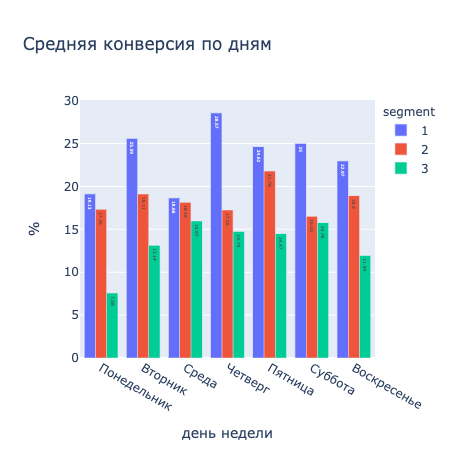

In [96]:
fig = px.bar(con_seg, x='index', 
             y='value', color='segment',
             text_auto=True,  barmode='group',
             labels={'index':'день недели', 'value':'%'},
             title=f'Средняя конверсия по дням')
fig.show()

Как можем помнить, конверсия по дням имеет пик пятницу. Для сегмента 2 результат тот же, но пик конверсии для пользоваталей сегмента 1 приходится на четверг, а для сегмента 3 на среду. Примечательно заметить, что по средам конверсии всез трех сегментов сравниваются и равны около 16-18.5%. 

In [97]:
s1 = conv_dyn_segments('week', week_numbers, "1", segment_1)
s2 = conv_dyn_segments('week', week_numbers, "2", segment_2)
s3 = conv_dyn_segments('week', week_numbers, "3", segment_3)

In [98]:
con_seg = pd.concat([s1,s2,s3],ignore_index=True, axis=0, )

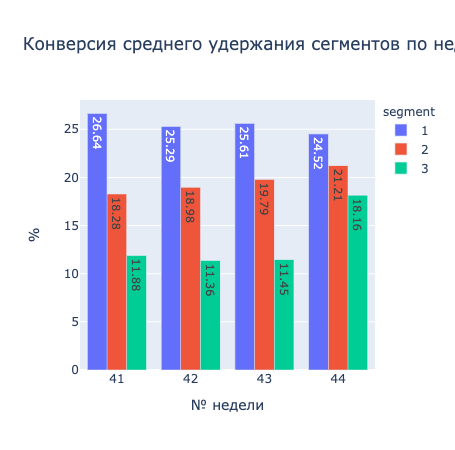

In [99]:
fig = px.bar(con_seg, x='index', 
             y='value', color='segment',
             text_auto=True,  barmode='group',
             labels={'value':'%', 'index':'№ недели'},
             title=f'Конверсия среднего удержания сегментов по неделям')
fig.show()

Понедельные конверсии выросли для 2 из 3 сегментов. На 52% выросла конверсия сегмента 3 от первой к четвертой неделе. Как ни странно, сегмент ЦА показал падение за 4 недели с 26.64% до 24.52%

**Вывод:** Конверсии, как и ожидалось, привязаны к сегментам. Напомним, что пользователи сегмента 1 является для компании целевой аудиторией, пользователи второго сегмента потенциальными ЦА, а 3-й группы – самый свежие или незаинтерисованные пользователи. 

Для сегмента 1 конверсия выше, чем для двух других. При этом конверсия не самых активных в плане времени и действий пользователей из сегмента 3 выросла в 1.5 раза и почти сравнялась с конверсией более активных юзеров. 

## Проверка гипотез

### Гипотеза 1

Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`.

**Гипотеза 1**: две эти группы демонстрируют разную конверсию в просмотры контактов.*
***

*__Нулевая гипотеза__: различий в конверсиях просмотров контактов между группами нет.*

*__Альтернативная гипотеза__: есть различия в конверсиях просмотров контактов между группами.*

Cчитаем статистику в ст.отклонениях стандартного нормального распределения, **alpha = 0.05**


In [100]:
yandex = sources[sources['source'] == 'yandex']
google = sources[sources['source'] == 'google']
y_size = yandex['user_id'].nunique()
g_size = google['user_id'].nunique()
y_cont = df[(df['user_id'].isin(yandex.user_id.to_list()) & (df['event_name'] == 'contacts_show'))]['user_id'].nunique()
g_cont = df[(df['user_id'].isin(google.user_id.to_list()) & (df['event_name'] == 'contacts_show'))]['user_id'].nunique()

In [101]:
alpha = 0.05  # критический уровень статистической значимости

contacts = np.array([y_cont, g_cont])
actions = np.array([y_size, g_size])

p1 = contacts[0] / actions[0]
p2 = contacts[1] / actions[1]

p_combined = (contacts[0] + contacts[1]) / (actions[0] + actions[1])
diff = p1 - p2

z_value = diff / mth.sqrt(p_combined * (1 - p_combined) * (1/actions[0] + 1/actions[1])) # ваш код

distr = st.norm(0, 1)# ваш код

p_value = (1 - distr.cdf(abs(z_value))) * 2# ваш код

print('Конверсия Yandex-юзеров:', round(p1,3))
print('Конверсия Google-юзеров:', round(p2, 3))
print()
print()
print('p-значение: ', p_value)

if p_value < alpha:# ваш код
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

Конверсия Yandex-юзеров: 0.247

Конверсия Google-юзеров: 0.244





p-значение:  0.8244316027993777

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:** Разница между конверсиями не оказалась значимой. Оба источника траифика показывают отличную конверсию в ЦД, которая не зависит от двух инструментов привлечения пользователей. p-value контексте интерпритации результата – вероятность получения таких или схожих результатов как наблюдаемые в выборке. В общем случае, чем меньше p-value, тем сильнее различия между выборками и тем более значимым они считаются.


### Гипотеза 2

Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`.

**Гипотеза 2**: две эти группы демонстрируют разный retention rate (на 7-й день)
***
*__Нулевая гипотеза__: различий в коэффициенте удержания между группами нет.*

*__Альтернативная гипотеза__: есть различия в коэффициенте удержания между группами.*

Z-тест для двух долей, **alpha = 0.05**


In [102]:
yandex = sources[sources['source'] == 'yandex'].user_id.to_list()
google = sources[sources['source'] == 'google'].user_id.to_list()

In [103]:
sessions = [get_sessions(df[df['user_id'].isin(users)]) for users in [yandex, google]]
profiles = [get_profiles(sessions[i]) for i in range(2)]
retentions = [get_retention(profiles[i], sessions[i], observation_date, horizon_days, ignore_horizon)[1] for i in range(2)]

retention_yandex, retention_google = retentions

y_coh = retention_yandex.iloc[:, 0].mean()
g_coh = retention_google.iloc[:, 0].mean()
y_p = round(retention_yandex.iloc[:, 0].mean() * retention_yandex.iloc[:, 7].mean())
g_p = round(retention_google.iloc[:, 0].mean() * retention_google.iloc[:, 7].mean())

In [104]:
alpha = 0.05  # критический уровень статистической значимости

retention = np.array([y_p, g_p])
cohorts = np.array([y_coh, g_coh])

p1 = retention[0] / cohorts[0]
p2 = retention[1] / cohorts[1]

p_combined = (retention[0] + retention[1]) / (cohorts[0] + cohorts[1])
diff = p1 - p2

z_value = diff / mth.sqrt(p_combined * (1 - p_combined) * (1/cohorts[0] + 1/cohorts[1])) 

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print(f'Средний Retention Rate Yandex-юзеров:{round(p1, 5) * 100}%')
print(f'Средний Retention Rate Google-юзеров:{round(p2, 4) * 100}%')

print()
print()
print('p-значение: ', p_value)

if p_value < alpha:# ваш код
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

Средний Retention Rate Yandex-юзеров:5.439%

Средний Retention Rate Google-юзеров:7.04%





p-значение:  0.72726397799652

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Как ни странно, разница между процентами удержания в 5.4% и 7% не оказалась значимой. Как и в предыдущем тесте, источник пользовательского траифика не влияет на поведение пользователей. 

## Вывод

Было проведено исследование данных о событиях и пользователях из внутренних источников приложения _"Ненужные вещи"_ **для нахождения интересных особенностей и закономерностей и презентации полученных результатов**. Результаты исследования могут быть учтены при разработке эффективных стратегий развития приложения.

Перед исследованием были поставлены следущие задачи:
* Сегментировать пользоваталей на основе действий;
* Определить, пользователи какой группы склонны чаще возвращаться в мобильное приложение (Retention rate);
* Определить, пользователи какой группы чаще совершают просмотр контактов (конверсия в целевое действие);
* Проверить гипотезу, что пользователи, установившие прилодение из`yandex` и `google` демонстрируют разную конверсию в просмотры контактов;
* Проверить гипотезу, что пользователи, установившие прилодение из`yandex` и `google` демонстрируют разный retention rate (на 7-й день).



***
1. **Задача:** _Сегментировать пользоваталей на основе действий_
Пользователи были поделены на 3 группы сегмента в зависимости от их активности в приложении. Уровень активнрсти определялся на основе действий и признаков: количество сессий в среднем, среднее времея сессий, среднее кол-во действий за сессию и коэффициент удержания. 
Сегмент, в который входит пользователь, определялся суммой баллов по 4 признакам. Распределение пользоваталей по сегментам вышло следующее:
    * Сегмент 1 – 24.5% или 1050 человек;
    * Сегмент 2 – 55.2% или 2370 человек;
    * Сегмент 3 – 20.3% или 873 человек;


2. **Задача:** _Определить, пользователи какой группы склонны чаще возвращаться в мобильное приложение (Retention rate)_
Более активные пользователи, входящие в первый сегмент, имеют наивысшее удержание, в то время как средний уровень удержания для пользователей сегмента 2 составляет 4.96%, немного ниже, чем среднее удержание для всех пользователей в целом - 6.02%. В сегменте 3 среднее удержание близко к 1%, что означает, что только 1 из 100 пользователей этой группы вернется в приложение на 7-й день. Несмотря на то, что удержание в общем падает для всех трех групп, на 7-й день удержание в первом и третьем сегментах выросло, но это скорее исключение из правил. Сегментирование пользователей по активности приводит к более высокому уровню удержания для более активных пользователей.


3. **Задача:** _Определить, пользователи какой группы чаще совершают просмотр контактов (конверсия в целевое действие)?_
Конверсия зависит от дня недели и сегментов, и конверсия пользователей сегмента 1 выше, чем у пользователей сегментов 2 и 3. Конверсия также может расти с течением времени, особенно у менее активных пользователей, но все еще остается зависимой от сегментов. 

4. **Гипотеза:** _Пользователи, установившие приложение из `yandex` и `google` демонстрируют разную конверсию в просмотры контактов_
Гипотеза не подтверждена. Конверсия меджду двумя группами различается на десятичные доли и данная разница не является статистически значимой для утверждения разницы конверсий пользователей из `yandex` и `google`. 

5. **Гипотеза:** _Пользователи, установившие приложение из`yandex` и `google` демонстрируют разный retention rate (на 7-й день)_
Гипотеза не подтверждена частично. Разница между процентами удержания двух групп есть, в 5.4% для `yandex` и 7% для `google`, но она оказалась не столь статистически значимой для утверждения, что пользователи демонстрируют разный коэффициент удержания. 


**Вывод**

В целом показатели приложения показывает позитивные и положительные результаты по уровню удержания пользователей, конверсии в просмотр контактов и притока новых пользователей, но ухудшение по среднему времени проведённого в приложении за день и за сессию для каждого из пользователей и ухудшение показателей сегмента целевой аудитории, для которой конверсия падает, а коэффициент удержания остается примерно на том же уровне, то есть стагнирует. 

Также было замечено, что почти 30% сессий заканчивались после одного совершенного действия. Этими действиями являются показ рекомендаций, поиск  и просмотр фотографий. Это может быть связано с тем что пользователям не удобен интерфейс или появляются какие-либо технические ошибки при использовании функционала "Ненужные Вещи". Это следует рассмотреть при разработке обновлений. Особенно акцентировать внимание на алгортмах рекомендаций, когда всего 2% пользователей просматривают рекомендации после ее показа 
